# 0.5) Import Libraries

In [ ]:
import numpy as np
import pandas as pd

from glob import glob

import matplotlib.pyplot as plt

import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

# 1) Download and View Dataset

In [ ]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username":"kennethweech","key":"c8281efcda36bd6dc0a595f81d2221f3"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
! kaggle competitions download -c state-farm-distracted-driver-detection
! mkdir dataset
! unzip state-farm-distracted-driver-detection.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/imgs/train/c7/img_56661.jpg  
  inflating: dataset/imgs/train/c7/img_56699.jpg  
  inflating: dataset/imgs/train/c7/img_56717.jpg  
  inflating: dataset/imgs/train/c7/img_56724.jpg  
  inflating: dataset/imgs/train/c7/img_56768.jpg  
  inflating: dataset/imgs/train/c7/img_56779.jpg  
  inflating: dataset/imgs/train/c7/img_56849.jpg  
  inflating: dataset/imgs/train/c7/img_56899.jpg  
  inflating: dataset/imgs/train/c7/img_56938.jpg  
  inflating: dataset/imgs/train/c7/img_5706.jpg  
  inflating: dataset/imgs/train/c7/img_57076.jpg  
  inflating: dataset/imgs/train/c7/img_57122.jpg  
  inflating: dataset/imgs/train/c7/img_57137.jpg  
  inflating: dataset/imgs/train/c7/img_5715.jpg  
  inflating: dataset/imgs/train/c7/img_57278.jpg  
  inflating: dataset/imgs/train/c7/img_57321.jpg  
  inflating: dataset/imgs/train/c7/img_57345.jpg  
  inflating: dataset/imgs/train/c7/img_57355.jpg  
  inflating: dataset/imgs/train/c

In [ ]:
files = glob("/content/dataset/imgs/train/*/*.jpg")
print("The number of images is: ", len(files))

The number of images is:  22424


In [ ]:
#The images in the test folder are unlabeled meaning for this model we will only be using the labeled data in the training folder
images = np.asarray(glob("/content/dataset/imgs/train/*/*.jpg"))
labels = np.asarray([f.split("/")[-2] for f in images])

In [ ]:
#Defining a function to return the actual labels of the data

# We have 10 classes to predict the causes of distraction.
# c0: normal driving
# c1: texting - right
# c2: talking on the phone - right
# c3: texting - left
# c4: talking on the phone - left
# c5: operating the radio
# c6: drinking
# c7: reaching behind
# c8: hair and makeup
# c9: talking to passenger
def get_descriptive_labels(labels):
  labels_descriptive = []
  for label in labels:
    if label == "c0" or label == 0:
      labels_descriptive.append("normal driving")
    elif label == "c1" or label == 1:
      labels_descriptive.append("texting - right")
    elif label == "c2" or label == 2:
      labels_descriptive.append("talking on the phone - right")
    elif label == "c3" or label == 3:
      labels_descriptive.append("texting - left")
    elif label == "c4" or label == 4:
      labels_descriptive.append("talking on the phone - left")
    elif label == "c5" or label == 5:
      labels_descriptive.append("operating the radio")
    elif label == "c6" or label == 6:
      labels_descriptive.append("drinking")
    elif label == "c7" or label == 7:
      labels_descriptive.append("reaching behind")
    elif label == "c8" or label == 8:
      labels_descriptive.append("hair and makeup")
    elif label == "c9" or label == 9:
      labels_descriptive.append("talking to passenger")
  return labels_descriptive

In [ ]:
#encoding labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labels_enc = le.fit_transform(labels)
labels_descriptive = get_descriptive_labels(labels)

In [ ]:
#checking lengths are the same
len(labels_enc), len(labels), len(labels_descriptive), len(images)

(22424, 22424, 22424, 22424)

In [ ]:
#checking unique labels
np.unique(labels_enc), np.unique(labels), np.unique(labels_descriptive)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'],
       dtype='<U2'),
 array(['drinking', 'hair and makeup', 'normal driving',
        'operating the radio', 'reaching behind',
        'talking on the phone - left', 'talking on the phone - right',
        'talking to passenger', 'texting - left', 'texting - right'],
       dtype='<U28'))

In [ ]:
#checking image shape
mpimg.imread(images[0]).shape

(480, 640, 3)

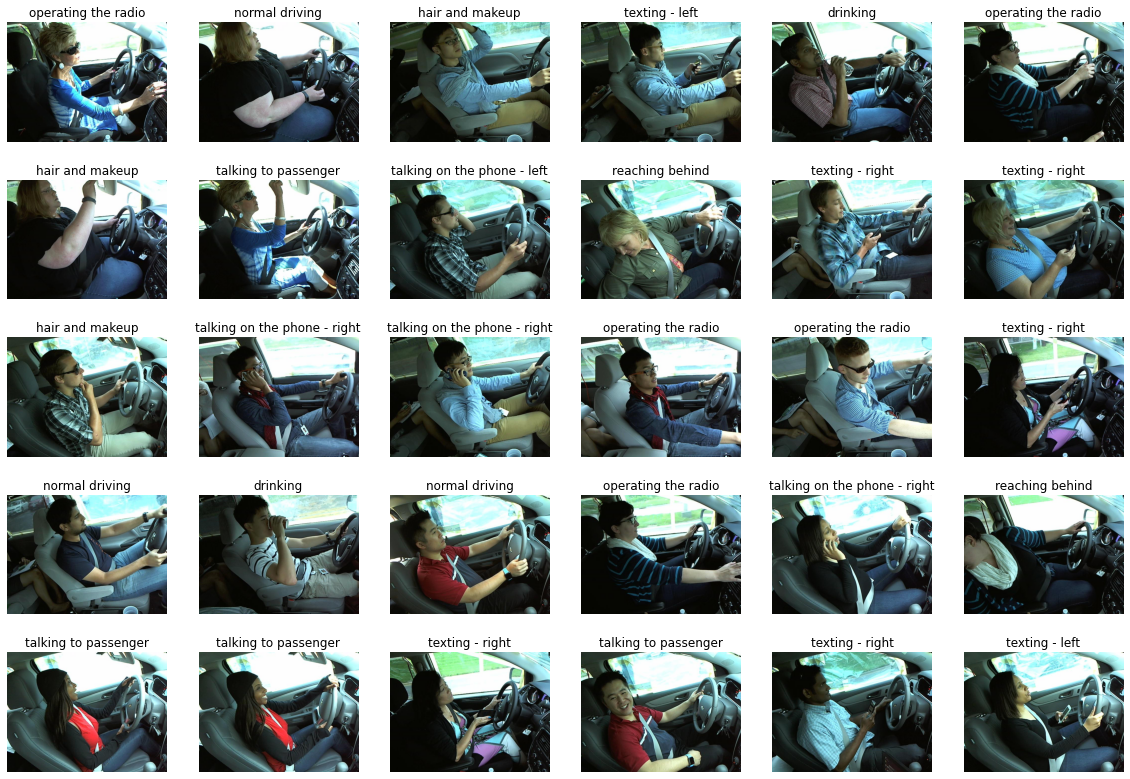

In [ ]:
#showing some example photos and labels
sample_indexes = np.random.choice(np.arange(images.shape[0], dtype = int),size = 30, replace = False)
fig = plt.figure(figsize=(20, 14))
count = 1
for i in sample_indexes:
  fig.add_subplot(5, 6, count)
  plt.imshow(mpimg.imread(images[i]))
  plt.axis('off')
  plt.title(labels_descriptive[i])
  count += 1

# 2) Transform Data For Transfer Learning Model

### Option 1) Random Train/Val/Test Split

In [ ]:
indexes = np.arange(len(images), dtype = int)
np.random.shuffle(indexes)
images_shuffled = images[indexes]
labels_shuffled = labels_enc[indexes]

#DOING THIS FOR COLAB AS MEMORY RUNS OUT. GRABBING 1000 SAMPLES
images_shuffled = images_shuffled[:1000]
labels_shuffled = labels_shuffled[:1000]

# Train/test split
nsplit1 = int(0.75*len(images_shuffled)) 
nsplit2 = int(0.9*len(images_shuffled)) 

from skimage import transform

#from documentation model uses 224x224
img_resize_height = 224
img_resize_width = 224

#loading images into X
X = np.zeros((len(images_shuffled),img_resize_height,img_resize_width,3))
for (i, img) in enumerate(images_shuffled):
    X[i] = transform.resize(plt.imread(img),(img_resize_height,img_resize_width,3))
#Note: each Keras Application expects a specific kind of input preprocessing. 
#For MobileNet, call tf.keras.applications.mobilenet.preprocess_input on your inputs before passing them to the model. 
#mobilenet.preprocess_input will scale input pixels between -1 and 1.
X = tf.keras.applications.mobilenet.preprocess_input(X*255)

Y = labels_shuffled
# Train and validation split

X_train = X[:nsplit1]
Y_train = Y[:nsplit1]
X_val = X[nsplit1:nsplit2]
Y_val = Y[nsplit1:nsplit2]
X_test = X[nsplit2:]
Y_test = Y[nsplit2:]

NameError: ignored

### Option 2) Train/Val/Test Based on Person
- Testing on individuals unseen in train data 

In [ ]:
#loading participants csv
participants = pd.read_csv("/content/dataset/driver_imgs_list.csv")
display(participants)

#getting participant list
unique_participants = participants["subject"].unique()
print("# of unique participants: ", len(unique_participants), "\n Unique participants: ", unique_participants)

#counting the number of images each participant is in
display(participants.groupby("subject").count())

# # of images each participant is in seems relatively even so we will choose who is in train/val/test arbitrarily
# 20 participants for training, 4 for validation, and 2 for testing
images[0][31:], participants["img"][0]

train_participants = participants.query("subject == 'p002' or subject == 'p012' or subject == 'p014' or subject == 'p015' or subject == 'p016' or subject == 'p021' or subject == 'p022' or subject == 'p024' or subject == 'p026' or subject == 'p035' or subject == 'p039' or subject == 'p041' or subject == 'p042' or subject == 'p045' or subject == 'p047' or subject == 'p049' or subject == 'p050' or subject == 'p051' or subject == 'p052' or subject == 'p056'").dropna()
val_participants = participants.query("subject == 'p061' or subject == 'p064' or subject == 'p066' or subject == 'p072'").dropna()
test_participants = participants.query("subject == 'p075' or subject == 'p081'").dropna()
#testing length
print("total participants should still be 22424 after splitting the up: ", len(train_participants) + len(val_participants) + len(test_participants))

image_names = []
for path in images:
  image_names.append(path[31:])
image_names = np.array(image_names)

#getting train indices
train_indices = []
for index, row in train_participants.iterrows():
  itemindex = np.where(image_names == row['img'])
  train_indices.append(itemindex[0][0])
#getting val indices
val_indices = []
for index, row in val_participants.iterrows():
  itemindex = np.where(image_names == row['img'])
  val_indices.append(itemindex[0][0])
#getting test indices
test_indices = []
for index, row in test_participants.iterrows():
  itemindex = np.where(image_names == row['img'])
  test_indices.append(itemindex[0][0])

from skimage import transform

#from documentation model uses 224x224
img_resize_height = 224
img_resize_width = 224

#loading images into X
X = np.zeros((len(images),img_resize_height,img_resize_width,3))
for (i, img) in enumerate(images):
    X[i] = transform.resize(plt.imread(img),(img_resize_height,img_resize_width,3))
#Note: each Keras Application expects a specific kind of input preprocessing. 
#For MobileNet, call tf.keras.applications.mobilenet.preprocess_input on your inputs before passing them to the model. 
#mobilenet.preprocess_input will scale input pixels between -1 and 1.
X = tf.keras.applications.mobilenet.preprocess_input(X*255)
Y = labels

X_train = X[train_indices]
Y_train = Y[train_indices]
X_val = X[train_indices]
Y_val = Y[train_indices]
X_test = X[train_indices]
Y_test = Y[train_indices]

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


# of unique participants:  26 
 Unique participants:  ['p002' 'p012' 'p014' 'p015' 'p016' 'p021' 'p022' 'p024' 'p026' 'p035'
 'p039' 'p041' 'p042' 'p045' 'p047' 'p049' 'p050' 'p051' 'p052' 'p056'
 'p061' 'p064' 'p066' 'p072' 'p075' 'p081']


,classname,img
subject,,
p002,725,725
p012,823,823
p014,876,876
p015,875,875
p016,1078,1078
p021,1237,1237
p022,1233,1233
p024,1226,1226
p026,1196,1196


total participants should still be 22424 after splitting the up:  22424


KeyboardInterrupt: ignored

In [ ]:
#checking X pixel range (needs to be -1 to 1)
X.min(), X.max()

(-0.9999999286671024, 1.0)

In [ ]:
len(X_train), len(Y_train)

(75, 75)

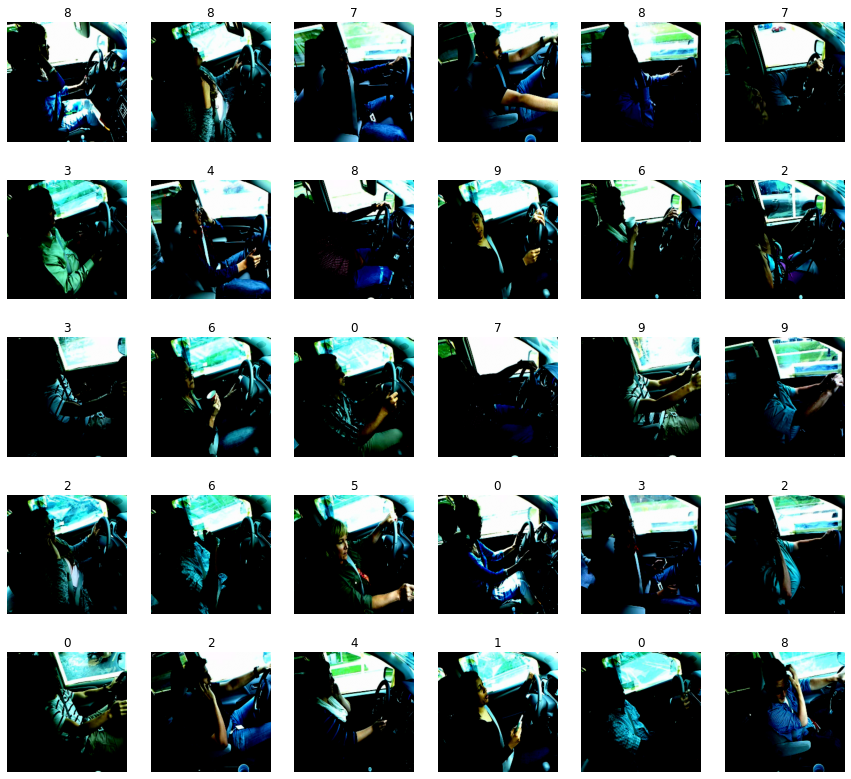

In [ ]:
#showing resized and re-pixeled images in training data
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
sample_indexes = np.random.choice(np.arange(len(X_train), dtype = int),size = 30, replace = False)
fig = plt.figure(figsize=(15, 14))
count = 1
for i in sample_indexes:
  fig.add_subplot(5, 6, count)
  plt.imshow(X_train[i])
  plt.axis('off')
  plt.title(Y_train[i])
  count += 1

#note we changed pixels from 0 to 1 to -1 to 1 so we will be getting a warning

In [ ]:
#checking shape of entire dataset
X_train.shape

(75, 224, 224, 3)

# 3) Defining Model

In [ ]:
#define callbacks 
#3 callbacks here
#1) early stopping with patience so if loss difference get's to low
#2) monitor callback after each epoch we save only the best model
#3) learning rate scheduler. 
model_name = "vgg_distracted_driving_cnn"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [ ]:
#loading model for transfer learning
#don't include top we are going to include our own
#model trainable means we aren't using it for training(freezing) (DO NOT TRAIN PARAMETERS). Remember we also need to freeze it's hyperparameters later
base_model = tf.keras.applications.MobileNet(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_resize_height, img_resize_width, 3),
    include_top=False) 
base_model.trainable = False
print(base_model.summary())

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
#input_image = tf.keras.Input(shape=(img_height, img_width, 3))
#define imputs and ouptus to model

#flag the hyperparameters to not train here (DO NOT TRAIN HYPERPARAMETERS). FREEZE INFERENCE MODE. before was training mode.
#so don't do dropout, batch normalization, etc..

x1 = base_model(base_model.input, training = False)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(len(np.unique(labels_shuffled)),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = base_model.input, outputs =out)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 10)                501770    
                                                                 
Total params: 3,730,634
Trainable params: 501,770
Non-trainable params: 3,228,864
_________________________________________________________________
None


# 3) Training Model

In [ ]:
#defining learning rate
#defining loss function
#defining metrics (accuracy for classification)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size = 32, epochs = 50, verbose = 1, callbacks= [early_stop, monitor, lr_schedule], validation_data = (X_val, Y_val))

Epoch 1/5
3/3 [==============================] - ETA: 0s - loss: 3.9355 - accuracy: 0.1200

3/3 [==============================] - 13s 5s/step - loss: 3.9355 - accuracy: 0.1200 - val_loss: 2.9386 - val_accuracy: 0.0667 - lr: 1.0000e-04
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 1.2816 - accuracy: 0.6000

3/3 [==============================] - 11s 5s/step - loss: 1.2816 - accuracy: 0.6000 - val_loss: 2.5991 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 3/5
3/3 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.8667

3/3 [==============================] - 17s 8s/step - loss: 0.4684 - accuracy: 0.8667 - val_loss: 2.4213 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 4/5
3/3 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.9867

3/3 [==============================] - 11s 5s/step - loss: 0.1509 - accuracy: 0.9867 - val_loss: 2.2733 - val_accuracy: 0.4667 - lr: 1.0000e-04
Epoch 5/5
3/3 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 1.0000

3/3 [==============================] - 12s 6s/step - loss: 0.0560 - accuracy: 1.0000 - val_loss: 2.2295 - val_accuracy: 0.4667 - lr: 5.0000e-05


In [ ]:
#now we are going to tweak/fine tune the entire model including tr
#we unfreeze the transfer model
model = tf.keras.models.load_model(model_name)
model.trainable = True

#VERY SMALL LEARNING RATE just to tweak model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-8),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

#then we train for just 5 more epochs just to tweak the model
model.fit(X_train, Y_train, batch_size = 32, epochs = 5, verbose = 1, callbacks= [early_stop, monitor, lr_schedule], validation_data = (X_val, Y_val))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 10)                501770    
                                                                 
Total params: 3,730,634
Trainable params: 3,708,746
Non-trainable params: 21,888
_________________________________________________________________
None
Epoch 1/5
3/3 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 1.0000

3/3 [==============================] - 23s 7s/step - loss: 0.0336 - accuracy: 1.0000 - val_loss: 2.2294 - val_accuracy: 0.4667 - lr: 1.0000e-08
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 1.0000

3/3 [==============================] - 18s 7s/step - loss: 0.0334 - accuracy: 1.0000 - val_loss: 2.2291 - val_accuracy: 0.4667 - lr: 1.0000e-08
Epoch 3/5
3/3 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 1.0000

3/3 [==============================] - 17s 7s/step - loss: 0.0332 - accuracy: 1.0000 - val_loss: 2.2289 - val_accuracy: 0.4667 - lr: 1.0000e-08
Epoch 4/5
3/3 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 1.0000

3/3 [==============================] - 19s 7s/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 2.2287 - val_accuracy: 0.4667 - lr: 1.0000e-08
Epoch 5/5
3/3 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 1.0000

3/3 [==============================] - 18s 7s/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 2.2286 - val_accuracy: 0.4667 - lr: 5.0000e-09


# 4) Evaluating Model

In [ ]:
model.load_weights(model_name)
metrics = model.evaluate(X_test,Y_test)

1/1 [==============================] - 0s 305ms/step - loss: 2.7254 - accuracy: 0.3000


In [ ]:
Y_pred = model.predict(X_test).argmax(axis = 1)

1/1 [==============================] - 1s 717ms/step


In [ ]:
# Displaying some test set and predictions
sample_indexes = np.random.choice(np.arange(len(Y_pred), dtype = int),size = 30, replace = False)
fig = plt.figure(figsize=(20, 20))
count = 1
Y_pred_descriptive = get_descriptive_labels(Y_pred)
Y_test_descriptive = get_descriptive_labels(Y_test)
for i in sample_indexes:
  fig.add_subplot(5, 6, count)
  #remapping pixels back to the range of 0 to 1 for viewing
  plt.imshow((X_test[i]+1)/2)
  plt.axis('off')
  plt.title("Predicted Label:\n %s\n True Label:\n %s" %(Y_pred_descriptive[i], Y_test_descriptive[i]))
  count += 1

ValueError: ignored

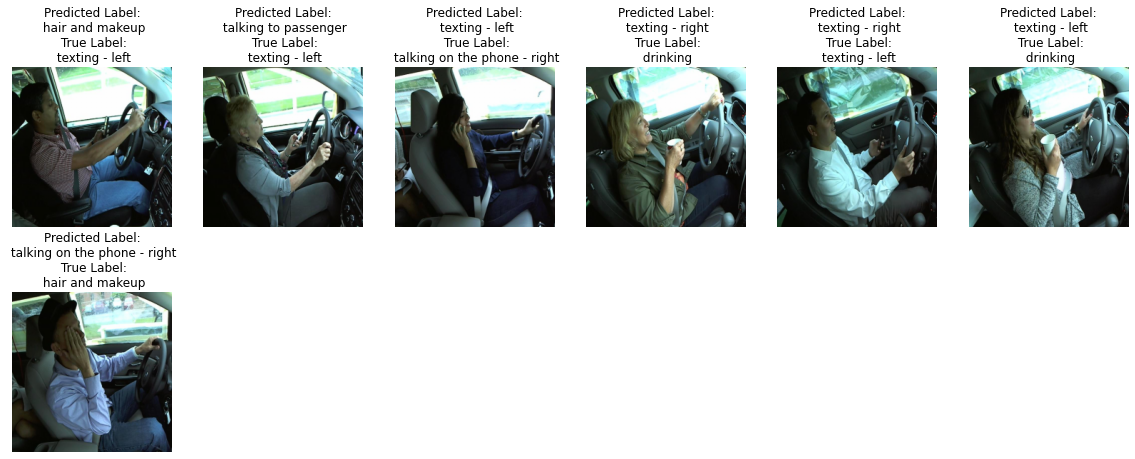

In [ ]:
#Displaying incorrectly predicted labels
wrong_indices = np.where(Y_pred != Y_test)[0]
fig = plt.figure(figsize=(20, 20))
count = 1
Y_pred_descriptive = get_descriptive_labels(Y_pred)
Y_test_descriptive = get_descriptive_labels(Y_test)
for i in wrong_indices:
  fig.add_subplot(5, 6, count)
  #remapping pixels back to the range of 0 to 1 for viewing
  plt.imshow((X_test[i]+1)/2)
  plt.axis('off')
  plt.title("Predicted Label:\n %s\n True Label:\n %s" %(Y_pred_descriptive[i], Y_test_descriptive[i]))
  count += 1
  if count > 30:
    break